In [19]:
import numpy as numpy
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torchvision
import kagglehub
import shutil
import os
from torch.utils.data import DataLoader, Dataset
import pathlib 
import torchvision.transforms as transforms
from PIL import Image

In [6]:
path = kagglehub.dataset_download("ayush1220/cifar10")
print("Path to dataset files:", path)

if os.path.isdir('./cifar10'):
    pass
else:
    shutil.move(os.path.join(path,'cifar10'),os.getcwd())


100%|██████████| 139M/139M [00:09<00:00, 15.3MB/s] 

Extracting files...


Path to dataset files: C:\Users\gratu\.cache\kagglehub\datasets\ayush1220\cifar10\versions\2


In [7]:
class_names = os.path.join(os.getcwd(),'cifar10','test')

class_names = os.listdir(class_names)
class_names.sort
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [24]:
class_dict = {num:name for name,num in enumerate(class_names)}
print("Dict for Class Name", class_dict)

Dict for Class Name {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [46]:
class cifarDS(Dataset):
    def __init__(self, path , transform= None):
        
        if not transform:
            self.transform = transforms.Compose([
                transforms.ToTensor()
            ])
            
        else:
            self.transform = transform
        self.all_images = list(pathlib.Path(path).glob("*/*.png"))
        
        
    def __len__(self):
        return len(self.all_images)
        
    def getImage(self,path):
        return Image.open(path)
        
    def __getitem__(self,index) :
        
        path  = self.all_images[index]
        
        image = self.getImage(path)
        class_dir = os.path.basename(os.path.dirname(path))
        classname = class_dict[class_dir]
        

        image = self.transform(image)
        
        return image,classname
        
        
        
        

In [26]:
train_dir = os.path.join(os.getcwd(),'cifar10','train')
test_dir  = os.path.join(os.getcwd(),'cifar', 'test')

In [42]:
train_dataset = cifarDS(path=train_dir, transform = train_transform)
test_dataset = cifarDS(path=test_dir)

In [43]:
train_transform = transforms.Compose([

        transforms.Resize(size=(224,224)),
        
                transforms.ToTensor(),


    transforms.Normalize(mean = [0.4914,0.4822,0.4465],std=[1.0,1.0,1.0])
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4914..0.50995684].


6


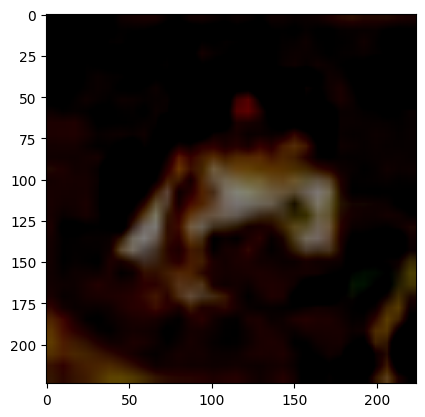

In [55]:
train_dataset[0]
#visualize image 

import matplotlib.pyplot as plt

plt.imshow(train_dataset[30000][0].permute(1,2,0))
print(train_dataset[30000][1])

In [ ]:
train_Dataloader = DataLoader(train_dataset,batch_size= 32, )